# What is LangGraph
LangGraph is a library designed for building stateful, multi-agent applications using large language models (LLMs). It extends the functionality of LangChain by allowing developers to coordinate multiple chains (or actors) across cyclic computational steps, making it suitable for more complex workflows and applications. Here are the main features and concepts behind LangGraph:

### Graph-Based Workflow:
LangGraph enables developers to create workflows as graphs, where each node represents an agent or a specific function, and edges define the transitions between these nodes. This structure supports both directed acyclic graphs (DAGs) and cyclic graphs, allowing for complex, stateful operations​ (LangChain AI)​​ (LangChain Blog)​.

### State Management:
The core component of LangGraph is the StateGraph, which manages a central state object that is updated by the nodes. This state can be modified by adding new information or by overwriting existing attributes, depending on the application needs.

### Multi-Agent Collaboration:
LangGraph supports multi-agent workflows, where each agent can be a specialized LLM or tool. These agents can work independently or collaboratively, sharing information as needed to accomplish tasks more effectively. This design helps in dividing complex problems into manageable units handled by different agents.

### Conditional Routing:
Nodes in a LangGraph can be connected with conditional edges, allowing dynamic decision-making based on the current state. This is useful for applications that require different actions based on user inputs or intermediate results, such as customer support assistants or automated workflows.

### Integration with Tools:
LangGraph easily integrates with various tools and APIs, allowing agents to perform specific actions like web searches, calculations, or database queries. This integration enhances the capabilities of the agents and makes the workflow more robust and versatile.

LangGraph is particularly useful for building applications that need to maintain state across multiple interactions, handle complex decision trees, and integrate seamlessly with external tools and APIs. It is an extension of LangChain, providing a higher level of abstraction for managing complex LLM-based workflows

## Smiple Graph
![Screenshot 2024-08-20 at 3.11.22 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png)

## State

First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph. 

Graph state in workflows refers to a structured way of keeping track of the information necessary for the workflow to operate correctly. This state is typically a collection of variables that can be updated and passed between different nodes in the workflow. It is dictionary-like structure that holds the information needed to track the progress and outcomes of a workflow.



Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

## Nodes
Nodes represent specific points or actions within the workflow. Each node performs a certain operation or check. 

or

## Nodes

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions.

The first positional argument is the state, as defined above.

Because the state is a `TypedDict` with schema as defined above, each node can access the key, `graph_state`, with `state['graph_state']`.

Each node returns a new value of the state key `graph_state`.
  
By default, the new value returned by each node [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value.


In [2]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

## Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) connect the nodes.

Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.

[Conditional Edges](https://langchain-ai.github.io/langgraph/reference/graphs/?h=conditional+edge#langgraph.graph.StateGraph.add_conditional_edges) are used want to *optionally* route between nodes.
 
Conditional edges are implemented as functions that return the next node to visit based upon some logic.

In [3]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

## Graph Construction

Now, we build the graph from our [components](
https://langchain-ai.github.io/langgraph/concepts/low_level/) defined above.

The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.
 
First, we initialize a StateGraph with the `State` class we defined above.
 
Then, we add our nodes and edges.

We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph.
 
The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. 

We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

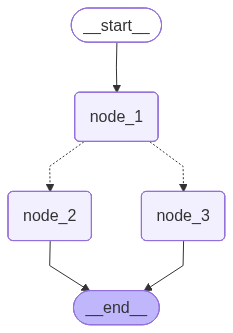

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Graph Invocation

The compiled graph implements the [runnable](https://python.langchain.com/v0.1/docs/expression_language/interface/) protocol.

This provides a standard way to execute LangChain components. 
 
`invoke` is one of the standard methods in this interface.

The input is a dictionary `{"graph_state": "Hi, this is lance."}`, which sets the initial value for our graph state dict.

When `invoke` is called, the graph starts execution from the `START` node.

It progresses through the defined nodes (`node_1`, `node_2`, `node_3`) in order.

The conditional edge will traverse from node `1` to node `2` or `3` using a 50/50 decision rule. 

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the `END` node.

In [5]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

---Node 1---
---Node 3---


{'graph_state': 'Hi, this is Lance. I am sad!'}

# Router

## Goals

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

This is an simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly. 

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

Let's extend our graph to work with either output! 

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model model output, and route to our tool calling node or simply end if no tool call is performed. 



In [10]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")


In [11]:

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatGroq(model="qwen/qwen3-32b")
llm_with_tools = llm.bind_tools([multiply])

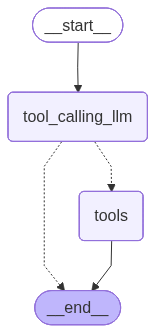

In [12]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages = graph.invoke({"messages": ("user", "Multiply 3 and 2")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 3 and 2
================================== Ai Message ==================================
Tool Calls:
  multiply (ybkd325b7)
 Call ID: ybkd325b7
  Args:
    a: 3
    b: 2
================================= Tool Message =================================
Name: multiply

6


: 